# Setting a custom anchor

This notebook gives an example how to add a custom anchor to your analysis using the main `qpcr` module.
It makes use of the provided example data in the `Example Data` directory. 


#### Experimental background

The corresponding experimental setup was as follows: 
Levels of Nonsense-mediated mRNA decay (NMD) sensitive (nmd) and insensitive (prot) transcript isoforms of HNRNPL and SRSF11 were measured by qPCR. As normalisers both 28S rRNA and Actin transcript levels were measured. Measurements were done in hexaplicates (6 replicates). This was done in two separate HeLa cell lines (one with a specific gene knockout (KO), and one without (WT)), which were both treated to a plasmid-mediated rescue (+) or not (-), leading to four experimental conditions:

| cell line \\ condition | rescue | no rescue |
| ---------------------- | ------ | --------- |
| knockout               | KO+    | KO-       |
| wildtype               | WT+    | WT-       |



#### First Analysis
The first Delta-Ct makes use of a dataset internal reference value (in our case the measured Ct from untreated wildtype (WT-)). Commonly the average of the reference Ct replicate values is used. The `qpcr` module opted to just use the very first entry of the dataset by default (assuming, of course, that the first group of replicates represents the reference group). However, what if you really want to use the average of the reference group to be the anchor? Well, in this case you can specify an anchor externally and add it directly to the `qpcr.Analyser`. We will see how to do this in this tutorial.

In [43]:
# import the qpcr module
import qpcr
import qpcr.Plotters as qplots

## Step 1 - Getting the data
---
First  we get the datafiles (or rather their filepaths). Here, we do this manually. Of course, any more automated process that yields a list of filepaths is also suitable.

In [44]:
# we set up the paths to 28S+actin as our normalisers
normaliser_files = [
    "../Example Data/28S.csv",
    "../Example Data/actin.csv"
]

# we also set up the paths to the HNRNPL and SRSF11 transcripts
sample_files = [
    "../Example Data/HNRNPL_nmd.csv",
    "../Example Data/HNRNPL_prot.csv",
    "../Example Data/SRSF11_nmd.csv",
    "../Example Data/SRSF11_prot.csv",
]

# a list for 28S and actin
normalisers = []
# a list for the HNRNPL and SRSF11 transcript isoforms
samples = []

## Step 2 - Setting up the Pipeline
---

### 2.1 Setting up the Pipeline
We are already familiar how to manually set up an analysis pipeline. If you are still unfamiliar with these steps, please check out the first tutorial in the `1_manual_tutorial.ipynb` notebook.

In [45]:
# setup the reader
reader = qpcr.SampleReader()

# now we define the setup parameters
# define the number of replicates for each group (group = condition)
reps = 6
reader.replicates(reps)

# define the names of the groups of replicates = names of conditions
# NOTE: The order has to match the order wihtin the raw datafile!
group_names = ["WT-", "WT+", "KO-", "KO+"] 
reader.names(group_names)

# setup analyser
analyser = qpcr.Analyser()

# setup normaliser
normaliser = qpcr.Normaliser()

### 2.2 Setting up the external anchor
Now comes the interesting part. We can specify a custom anchor by computing the anchor externally and then pass the computed numeric value directly to the analyser. To make this more convenient, we will write a little function that will get the first replicate group, and average the Ct values.

In [46]:
def first_average(assay : qpcr.Assay):
    """
    This function gets the first group (group 0), which is the reference group, 
    and returns their average Ct value. It works with a qpcr.Assay object
    """
    df = assay.get() # get the stored dataframe from the Assay
    ref = df.query("group == 0")["Ct"]
    avg = ref.mean()
    return avg

## Step 3 - Running everything
---
### 3.1 Adding our custom anchor to the pipeline
Now we take the workflow from the first tutorial, and all we have to do is add our custom anchor function in front of the `analyser.pipe()` step.

In [47]:
# we first iterate over the normalisers 28S and actin
for norm in normaliser_files:
    norm = reader.read(norm)
    
    # compute custom anchor
    custom_anchor = first_average(norm)
    # pass custom anchor to analyser
    analyser.anchor(custom_anchor)
    
    norm = analyser.pipe(norm)
    normalisers.append(norm)

# and we do the same for our sample assays of HNRPL and SRSF11
for sample in sample_files:
    sample = reader.read(sample)

    custom_anchor = first_average(sample)
    analyser.anchor(custom_anchor)

    sample = analyser.pipe(sample)
    samples.append(sample)

### 3.2 Finishing up
At this point we simply need to run the second step in Delta-Delta-Ct, the normalisation against our normaliser assays Actin and 28S. And inspect the results afterward.

In [48]:
# add the assays to the normaliser 
normaliser.link(samples = samples, normalisers = normalisers)

# and run the normalisation
normaliser.normalise()

results = normaliser.get().stats()
results

/Users/NoahHK/opt/anaconda3/lib/python3.8/site-packages/qpcr/__init__.py:1260: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  tmp_df = tmp_df.mean(axis = 1)


,group,assay,mean,stdev,median,group_name
0,0,HNRNPL_nmd_rel_28S+actin,0.996925,0.031751,1.001800,WT-
4,1,HNRNPL_nmd_rel_28S+actin,5.650216,0.835556,5.926360,WT+
8,2,HNRNPL_nmd_rel_28S+actin,9.148520,0.473316,9.180616,KO-
12,3,HNRNPL_nmd_rel_28S+actin,16.185170,1.188382,16.143396,KO+
1,0,HNRNPL_prot_rel_28S+actin,0.997374,0.044757,0.983061,WT-
5,1,HNRNPL_prot_rel_28S+actin,0.873953,0.050710,0.876917,WT+
9,2,HNRNPL_prot_rel_28S+actin,0.839504,0.031261,0.845369,KO-
13,3,HNRNPL_prot_rel_28S+actin,0.906150,0.063912,0.910838,KO+
2,0,SRSF11_nmd_rel_28S+actin,1.002857,0.114905,0.979897,WT-
6,1,SRSF11_nmd_rel_28S+actin,3.758608,0.711593,4.048361,WT+


## Default `"first"` vs. custom `"mean"` anchor
----------------------------------------------------------------

You may be wondering how the results differ between the default settings and the ones using our custom mean-anchor. Let's compare the results. We will compute results using default settings through the predefined `Basic` pipeline. 

In [49]:
# get default results using the Basic pipeline
from qpcr.Pipes import Basic

basic = Basic()
basic.replicates(reps)
basic.names(group_names)
basic.add_assays(sample_files)
basic.add_normalisers(normaliser_files)
basic.run()
results_pipe = basic.get()

results_pipe

/Users/NoahHK/opt/anaconda3/lib/python3.8/site-packages/qpcr/__init__.py:1260: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  tmp_df = tmp_df.mean(axis = 1)


,group,assay,mean,stdev,median,group_name
0,0,HNRNPL_nmd_rel_28S+actin,1.050056,0.029452,1.050267,WT-
4,1,HNRNPL_nmd_rel_28S+actin,6.052860,0.890336,6.366251,WT+
8,2,HNRNPL_nmd_rel_28S+actin,9.566500,0.513593,9.614924,KO-
12,3,HNRNPL_nmd_rel_28S+actin,16.940332,1.126687,16.964906,KO+
1,0,HNRNPL_prot_rel_28S+actin,1.025239,0.040091,1.006244,WT-
5,1,HNRNPL_prot_rel_28S+actin,0.913758,0.050860,0.917271,WT+
9,2,HNRNPL_prot_rel_28S+actin,0.856658,0.029906,0.862768,KO-
13,3,HNRNPL_prot_rel_28S+actin,0.925665,0.057855,0.931949,KO+
2,0,SRSF11_nmd_rel_28S+actin,0.885403,0.102865,0.857620,WT-
6,1,SRSF11_nmd_rel_28S+actin,3.374373,0.638138,3.644576,WT+


Next we visualise the results as barplots and check the fold-change between our custom results and the default results.

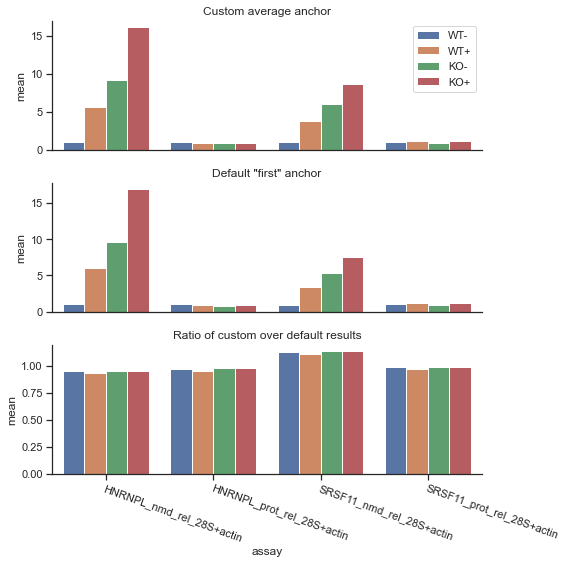

In [108]:
# visualise our results (we can ignore the code here, just the figure is of interest...)
import matplotlib.pyplot as plt
import seaborn as sns 

fig, axs = plt.subplots(3, figsize = (8,8))

sns.barplot(
            data = results, 
            x = "assay", 
            y = "mean", 
            hue = "group_name", 
            ax = axs[0]
        )

sns.barplot(
            data = results_pipe, 
            x = "assay", 
            y = "mean", 
            hue = "group_name", 
            ax = axs[1]
        )

diff_means = results["mean"] / results_pipe["mean"]

sns.barplot(
    data = results,
    x = "assay",
    y = diff_means,
    hue = "group_name",
    ax = axs[2]
)

for ax in axs: 
    plt.setp( ax.xaxis.get_majorticklabels(), rotation=-20, ha="left", rotation_mode="anchor") 
    ax.legend().remove()
    ax.set(xlabel="", xticks = [])
axs[0].legend()
axs[2].set(xlabel = "assay", xticks = [0,1,2,3])

axs[0].set(title = "Custom \"mean\" anchor")
axs[1].set(title = "Default \"first\" anchor")
axs[2].set(title = "Ratio of custom over default results")
sns.set_style("ticks")
sns.despine()
plt.tight_layout()

In our example dataset, computing an external anchor did not seem to impact our overall results markedly. Well, that's a relief :-) 

So, does that mean we should simply rely on default settings? Not necessarily. If your data is spread over a larger range of Ct values for each group (you can check the distribution of your data using the `qpcr.Filter` classes, see the third tutorial `3_filter_tutorial.ipynb`), you may not want to rely on a just the first one of your datapoints to be your anchor (after all it could just barely have passed the filter). In such cases you may rather want to rely on a mean or median of your entire reference group.

In fact, this approach works not only for the `anchor` but with other attributes of the `qpcr` processing classes as well. So, today you learned how to link your own computations to `qpcr`'s workflow, which will enable you to produce even more streamlined computations to your needs.